In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

## 데이터 분석 주제: 서울시 아파트 가격 결정에 영향을 미치는 여러 요인 분석
   

    1) 지하철역 분포와 가격비교 - 이재호
    2) 층별로 가격비교 - 오형석
    3) 선호하는 브랜드 확인 -오형석
    4) 30년 이상인 아파트들의 개수와 가격비교 - 윤슬아
    5) 공시지가에 따른 가격비교 - 임해리
    6) 전체 인구밀도와 가격비교 -임해리
    7) 사설학원과 학생수에 따른 가격비교 -이수영 
    
    외부 데이터
     - 서울시 공시지가
     - 서울시 지하철 데이터
     - 구별 인구밀도(1인당 자동차 등록 대수)
     - 서울시 학생 1만명당 사설학원수 통계
     - 서울시 학급당 학생수(구별) 통계
     

## 데이터 전처리

    1) 주거형태 아파트만 한정
    
    2) 건물면적 평으로 수정
    
    3) 0.0년 2020년으로 수정
    
    4) 법정동코드는 [시군구명, 읍면동면]만 사용

### 1. 법정동 코드 가공

In [3]:
locCode = pd.read_excel("../data/법정동코드.xlsx")
locCode.dropna(subset = ['읍면동명'], how = 'any', axis=0)
locCode.dropna(subset = ['시군구명'], how = 'any', axis=0)
locCode['지역코드']=(locCode['법정동코드']/10000).astype(int)
locCode=locCode[locCode['시도명']=='서울특별시']
apt = pd.read_csv('../data/2020년 서울 아파트 실거래가.csv', encoding="cp949")
locCode.rename(columns = {'읍면동명' : '법정동명'}, inplace = True)
df = pd.merge(apt,locCode,on='법정동명')
df = df[df['건물주용도']=='아파트']
df.drop(['법정동코드', '시도명', '동리명', '생성일자', '말소일자','지역코드','건물주용도코드'], axis=1, inplace=True)
df['평당가'] = (df['거래금액']/(df['건물면적']/3.3)).astype(int)
df['건축년도'] = df['건축년도'].replace(0.0,2020)
df

,법정동명,건물면적,층정보,건물주용도,거래금액,건축년도,아파트명,시군구명,평당가
0,장위동,59.92,5.0,아파트,749000000,2020.0,래미안 장위포레카운티,성북구,41249999
1,장위동,116.91,2.0,아파트,1270000000,2020.0,래미안장위퍼스트하이,성북구,35848088
2,장위동,59.99,17.0,아파트,820000000,2020.0,래미안장위퍼스트하이,성북구,45107517
4,장위동,84.48,12.0,아파트,1150000000,2020.0,꿈의숲 아이파크,성북구,44921875
5,장위동,84.48,18.0,아파트,1300000000,2020.0,꿈의숲 아이파크,성북구,50781250
...,...,...,...,...,...,...,...,...,...
179762,현석동,84.98,7.0,아파트,1680000000,2016.0,래미안 웰스트림,마포구,65238879
179763,현석동,84.98,30.0,아파트,1845000000,2016.0,래미안 웰스트림,마포구,71646269
179764,현석동,84.98,17.0,아파트,1845000000,2016.0,래미안 웰스트림,마포구,71646269
179766,현석동,59.40,3.0,아파트,930000000,1999.0,밤섬힐스테이트,마포구,51666666


## 1. 지하철역 분포와 가격비교

In [4]:
#지하철역 엑셀 불러오기
subway = pd.read_excel('../data/서울교통공사_역주소 및 전화번호_20200715.xlsx')

#불러온 지하철역의 구별 주소 작성
subway['구'] = subway['역주소'].str.split(" ").str[1]

#구별 지하철역 갯수
#지하철에 서울 외 지역이 포함되어 있어 제거
subway = subway[~subway['구'].str.contains('시')]
subway = subway.drop_duplicates(subset=['역명'])
subway.groupby('역명').count()
sub_pivot = subway.pivot_table(index='구',values='연번',aggfunc='count')
# 갯수 순서정렬
sub_pivot = sub_pivot.reindex(sub_pivot.sort_values(by='연번', ascending=False).index)
sub_pivot.head()

#구별 평당가(원)
#pd.options.display.float_format = '{:.0f}'.format #원 단위 맞추기위해 소수점제거
apt_pivot = df.pivot_table(index='시군구명',values=['평당가'],aggfunc='mean')
apt_pivot

,평당가
시군구명,
강남구,6.356002e+07
강동구,3.801496e+07
강북구,2.494667e+07
강서구,3.153346e+07
관악구,2.866477e+07
광진구,4.184644e+07
구로구,2.519423e+07
금천구,2.410681e+07
노원구,2.732576e+07


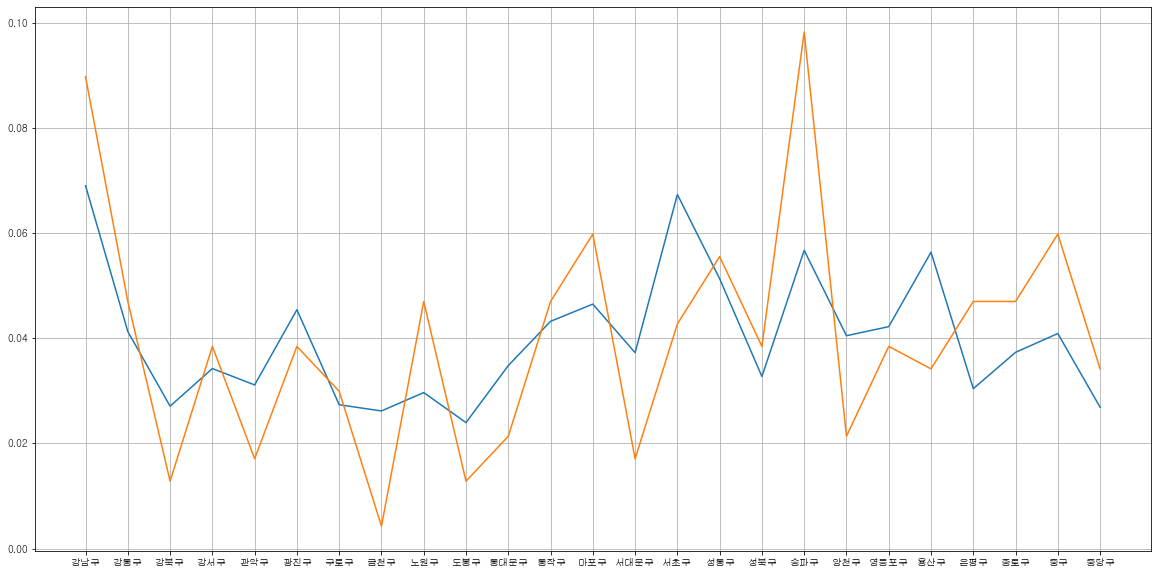

In [39]:
# 평당가와 연번 비율 그래프
from matplotlib import font_manager, rc

table = pd.merge(apt_pivot,sub_pivot,left_index=True,right_index=True)

table['연번'] = table['연번'].astype(float)/table['연번'].astype(float).sum(axis=0)
table['평당가'] = (table['평당가'].astype(float)/table['평당가'].sum().astype(float)).astype(float)


plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Gulim'
plt.rcParams["figure.figsize"] = (20,10)
plt.grid(True)
plt.plot(table)
plt.show()

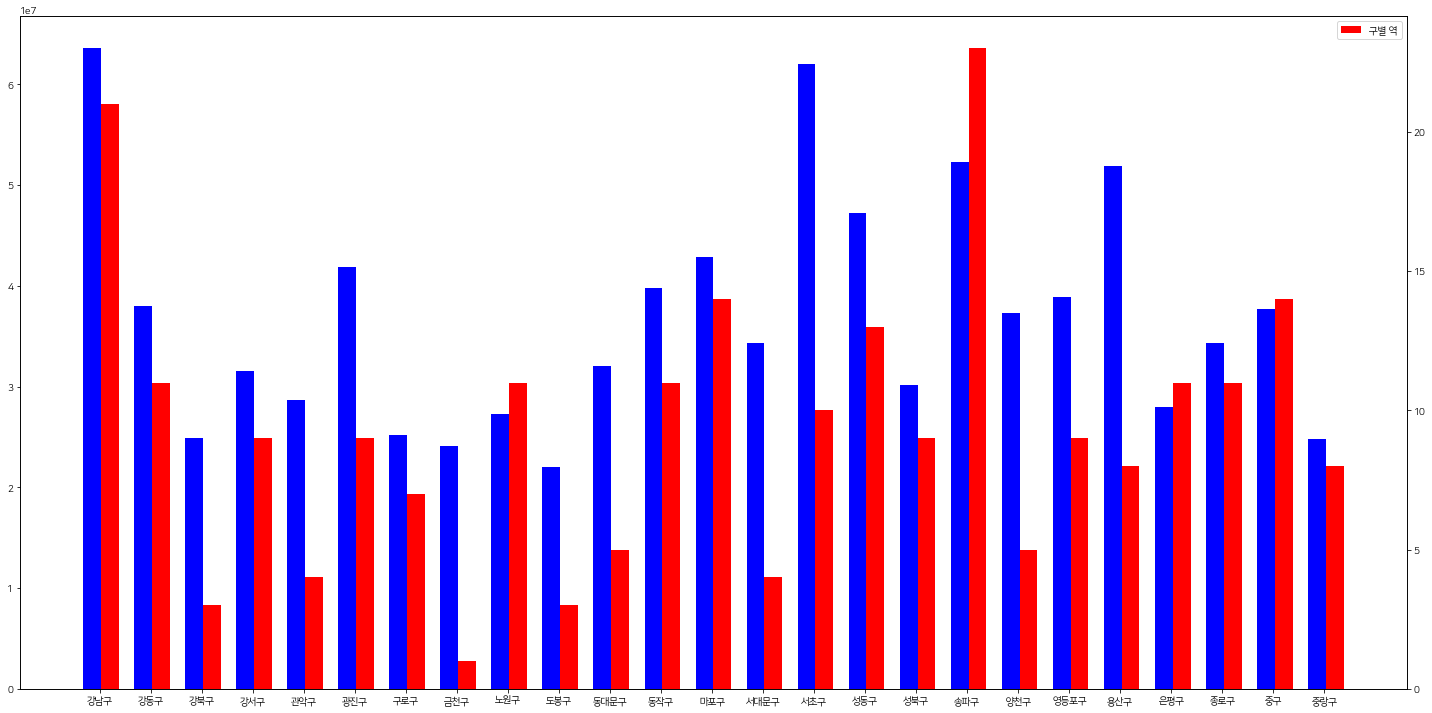

In [38]:
#구별 평당가와 역갯수 비교
#파란색 = 평당가, 빨간색 = 구별 역갯수
table = pd.merge(apt_pivot,sub_pivot,left_index=True,right_index=True)
table = table.reset_index().rename(columns={'index':'시군구명'})

a = table['평당가']
b = table['연번']
ind = np.arange(25)
width = 0.35

plt.rcParams["figure.figsize"] = (20,10)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.bar(ind+width, a, width, color='Blue', label='평당가')
ax2 = ax.twinx()
ax2.bar(ind+width+0.35, b, width, color='Red', label='구별 역')

ax.set_xticks(ind+width+(width/2))
ax.set_xticklabels(a)

plt.tight_layout()
plt.legend()
plt.xticks(ind+0.5 ,labels=table['시군구명'],rotation=45)
plt.show()

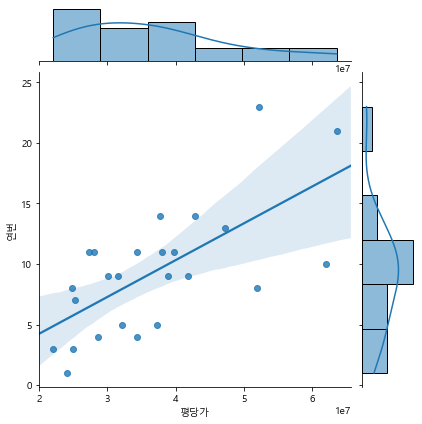

In [6]:
#평당가와 지하철역 갯수의 상관관계 그래프
sns.jointplot(x='평당가',y='연번',
              data=table,
              kind="reg", truncate=False,)

<AxesSubplot:>

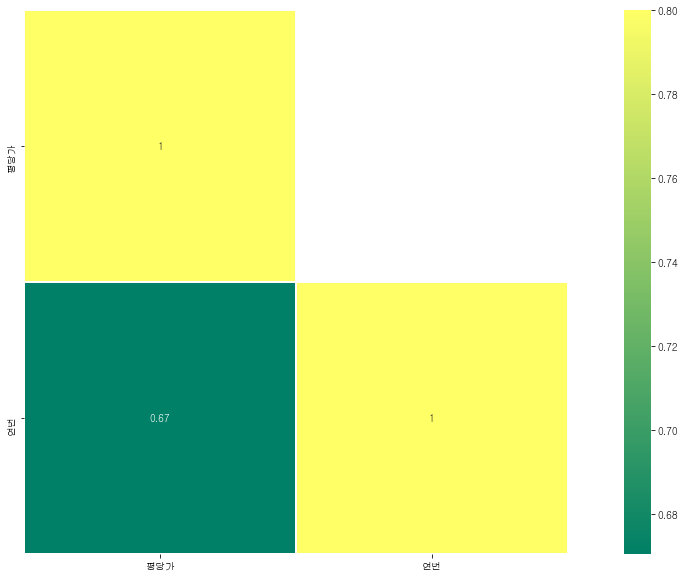

In [8]:
#평당가 비율그래프에서 관계가 있어보이지만
# 명확한 수치로 나타내기 위한 관계수치
corr1 = table[['평당가','연번']]
corr1 = corr1.corr()
mask = np.array(corr1)
mask[np.tril_indices_from(mask)] = False 
sns.heatmap(corr1,
            mask=mask,
            vmax=0.8,
            square=True,
            annot=True,
            linewidths=0.8,
            cmap='summer'
           )

### 분석결과

### 지하철역의 갯수와 아파트 거래가는 상관관계를 가진다.

- 바 그래프에서 대부분의 구가 지하철역 갯수와 평당가가 비례했다.
- 평당가와 연번의 상관관계 그래프가 우상향을 가르키고 있다.
- 평당가와 연번의 비율 그래프에서 비슷해 보이지만 예외지역이 있다.
- 피어슨 상관계수 결과가 0.67 -> 영향력이 있다고 볼 수 있다.

## 2. 층별로 가격비교 

In [9]:
#아파트명이 명확하지 않은 데이터 사용자 정의함수 이용하여 처리
df.pivot_table(index=['아파트명','법정동명'],values=['층정보','평당가']).astype(int)
def find_error_apt(df):
    del_index = df[(df['아파트명'].str.startswith("(")==True) & (df['아파트명'].str.endswith(")")== True)].index
    return del_index
df.drop(find_error_apt(df),inplace=True)
#층별 가격 비교
df_floor = (df.groupby(['아파트명','층정보'])[['평당가']].mean().sort_values("평당가",ascending=False)).astype(int)

floor_2 = []
floor_5 = []
floor_4 = []
floor_6 = []
floor_7 = []
floor_8 = []
floor_15 = []


for i in range(len(df_floor)):
    floor_5.append(df_floor.index[i][1]==5)
df_5 = df_floor[floor_5]


for i in range(len(df_floor)):
    floor_4.append(df_floor.index[i][1]==4)
df_4 = df_floor[floor_4]

for i in range(len(df_floor)):
    floor_6.append(df_floor.index[i][1]==6)
df_6 = df_floor[floor_6]

for i in range(len(df_floor)):
    floor_7.append(df_floor.index[i][1]==7)
df_7 = df_floor[floor_7]

for i in range(len(df_floor)):
    floor_8.append(df_floor.index[i][1]==8)
df_8 = df_floor[floor_8]

for i in range(len(df_floor)):
    floor_2.append(df_floor.index[i][1]==2)
df_2 = df_floor[floor_2]

for i in range(len(df_floor)):
    floor_15.append(df_floor.index[i][1]==15)
df_15 = df_floor[floor_15]

(-0.5, 799.5, 799.5, -0.5)

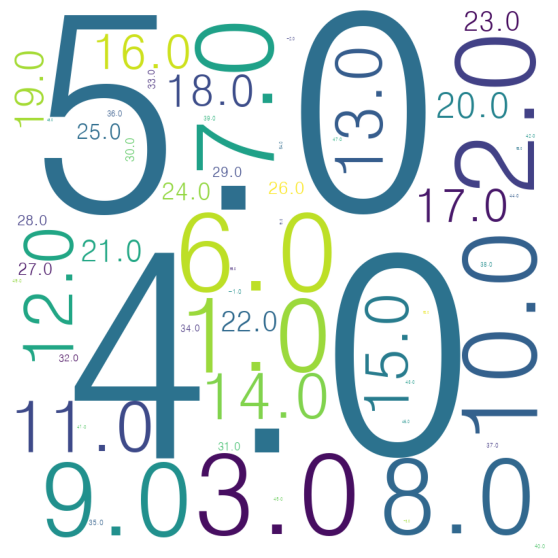

In [10]:
# 선호하는 층 수 현황
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
floor_list = []

for floor in df['층정보']:
    floor = str(floor)
    floor_list.append(floor)

floor_list_dict = Counter(floor_list)
floor_list_dict


wc1 = WordCloud(max_font_size=400,font_path='‪C:\Windows\Fonts\H2GTRM.TTF',
                 background_color='white', width=800, height=800)
wc1.generate_from_frequencies(floor_list_dict)

plt.figure(figsize=(16,10))
plt.imshow(wc1)
plt.axis('off')

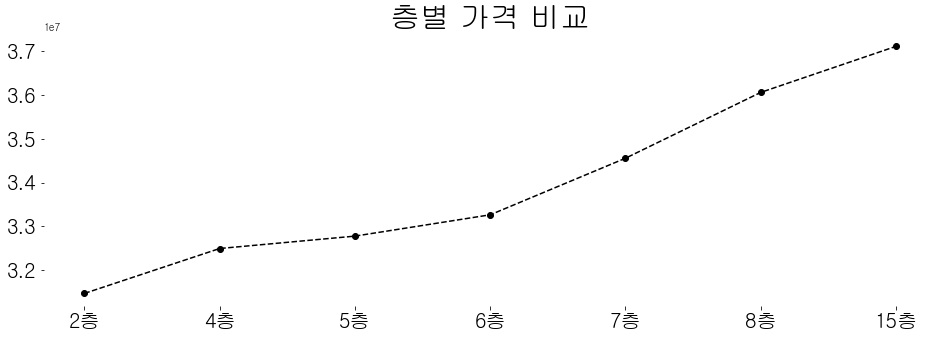

In [11]:
#층별 가격 비교 
df_average = [df_2.mean(),df_4.mean(),df_5.mean(),df_6.mean(),df_7.mean(),df_8.mean(),df_15.mean()]
df_floor = ['2층','4층','5층','6층','7층','8층','15층']


plt.figure(figsize=(16,5))
plt.title("층별 가격 비교",size = 30)
plt.plot(df_floor,df_average,'--o',color="black",)
plt.xticks(size=20)
plt.yticks(size=20)
plt.box(False)
plt.show()


          건축년도       층정보       평당가      거래금액
건축년도  1.000000  0.178610  0.104299  0.064934
층정보   0.178610  1.000000  0.167899  0.193420
평당가   0.104299  0.167899  1.000000  0.746421
거래금액  0.064934  0.193420  0.746421  1.000000


<Figure size 1152x720 with 0 Axes>

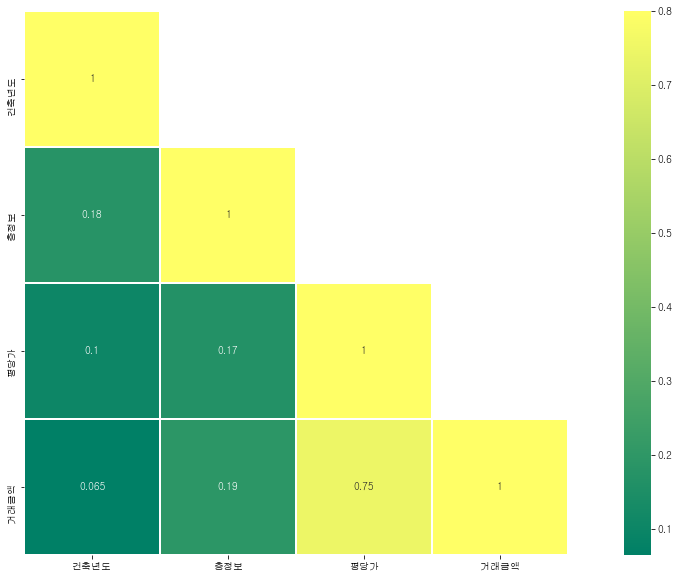

<Figure size 1152x720 with 0 Axes>

In [12]:
## 건축년도, 층정보, 평당가, 거래금액에 상관계수
corr1 = df[['건축년도','층정보','평당가','거래금액']]
corr1 = corr1.corr()
print(corr1)

mask = np.array(corr1)
mask[np.tril_indices_from(mask)] = False 
sns.heatmap(corr1,
            mask=mask,
            vmax=0.8,
            square=True,
            annot=True,
           linewidths=0.8,
            cmap='summer'
           )
plt.figure(figsize=(16,10))

### 분석결과
    층수를 워드 클라우드로 확인했을때 4층과 5층의 빈도수가 높아 4~5층의 선호도가 높을 것이라고 예상했는데 층별 가격평균을 계산해보니 층이 높아질 수록 가격이 평균가격이 올라가는 형태로 나와서 층수에 대한 분석을 피어슨 상관분석으로 더 분석을 했는데 평당가격과 층정보는 거의 관련이 없었다. 따라서 해당 부분은 분석이 더 필요하다고 생각된다.

## 3. 선호하는 브랜드 확인 

In [13]:
# 구 0 -- > 25
#  구[] == [아파트명]
#     이놈을 wordcloud
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

gu_list = ['성북구', '구로구', '용산구', '성동구', '광진구', '중구', '마포구', '중랑구', '양천구',
       '동대문구', '노원구', '송파구', '서초구', '은평구', '도봉구', '서대문구', '강동구', '영등포구',
       '관악구', '동작구', '금천구', '종로구', '강남구', '강북구', '강서구']

all_list = []
    

def remove_space(x): # 공백없애기 
    return x.replace(' ', '')

df['아파트명'] = df['아파트명'].apply(remove_space)

    
for gu in gu_list:
    apt_list=[]
    apt_list.append(list(df[df['시군구명']==gu]['아파트명']))
    all_list.append(apt_list)

fig = plt.figure(figsize=(50,50))
rows = 5
cols = 5
j = 1
for i in range(len(gu_list)):
    all_list_new = Counter(np.array(all_list[i]).flatten().tolist()) # 차원바꾸는거 / 
    wc1 = WordCloud(max_font_size=200,font_path='‪C:\Windows\Fonts\H2GTRM.TTF',
                 background_color='white', width=800, height=800)
    wc1.generate_from_frequencies(name_dict)
    
    ax = fig.add_subplot(rows, cols, j)    
    ax.set_title(f"{gu_list[i]}별 아파트 현황",fontsize=50)
    ax.imshow(wc1,interpolation='bilinear')
    plt.axis('off')
    j += 1
    
plt.show()

NameError: name 'name_dict' is not defined

<Figure size 3600x3600 with 0 Axes>

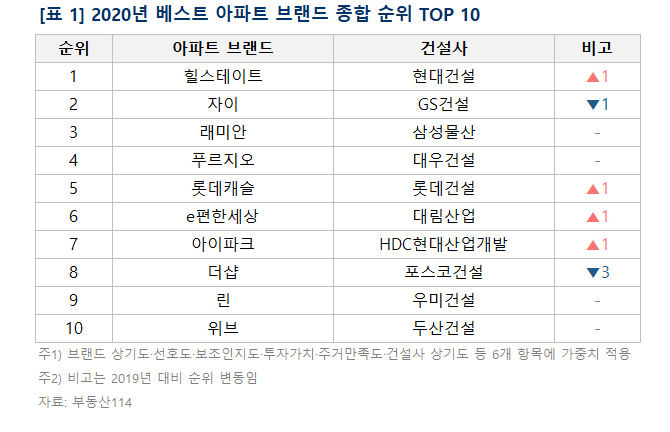

In [47]:
from IPython.display import Image

Image("../data/아파트 브랜드.png")

### 분석결과
    부동산 114의 자료와 대조 했을 때 워드클라우드의 결과와 어느정도 일치하여 선호하는 브랜드의 거래량이 많다는 것을 알 수 있었다.

## 4.  30년 이상인 아파트들의 개수와 가격비교

In [40]:
# 건축년도가 1990년 이하인 아파트 출력(아파트 평균 수명은 30년)
oldapt = df[df['건축년도']<=1990]
#구별 아파트 개수를 알기위해 중복 아파트 데이터는 하나만 남기고 제외
apt_result = oldapt.drop_duplicates(['아파트명','법정동명'],keep="first")
#구별 노후아파트 개수
sub_pivot = apt_result.pivot_table(index='시군구명',values='건축년도',aggfunc='count')
sub_pivot.rename(columns = {'건축년도' : '노후아파트 개수'}, inplace = True)

#갯수 순서정렬
sub_pivot = sub_pivot.reindex(sub_pivot.sort_values(by='노후아파트 개수', ascending=False).index)
#구별 노후아파트 평당가 평균
price = oldapt.pivot_table(index='시군구명',values='평당가',aggfunc='mean')
p1 = price.astype({'평당가': 'int'})

final_result = pd.merge(sub_pivot,p1,on='시군구명')
result_sorted_by_values = final_result.sort_values(by='평당가',ascending=True)
result_sorted_by_values

,노후아파트 개수,평당가
시군구명,,
강북구,3,14154231
성북구,13,15374285
중구,13,20113320
서대문구,25,22143518
은평구,11,22857590
도봉구,26,23018359
중랑구,10,23356855
강서구,12,24297625
종로구,8,24990549


<AxesSubplot:>

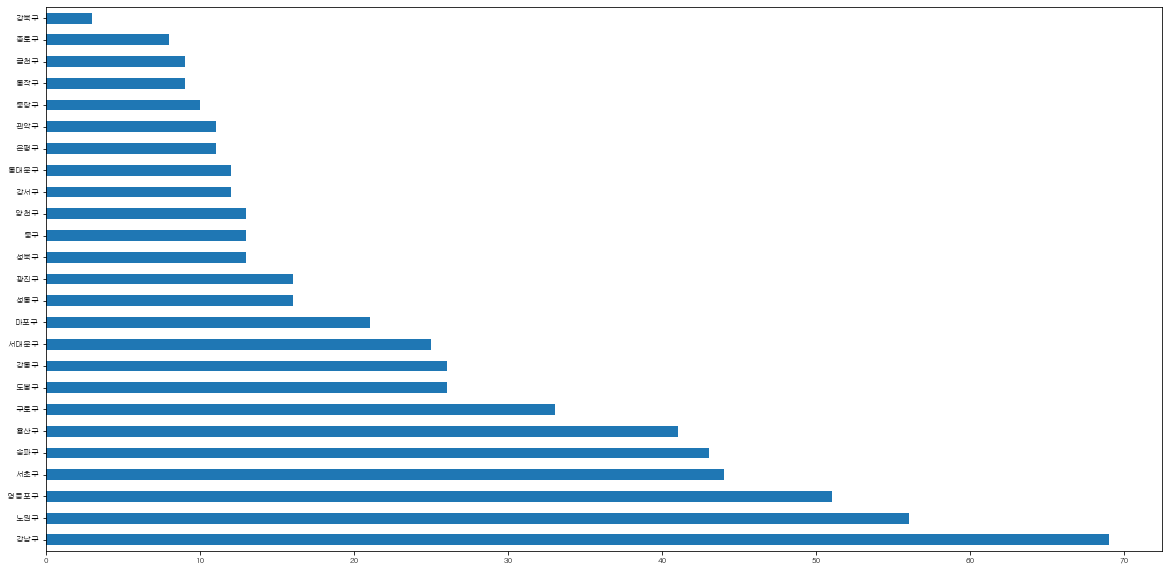

In [41]:
result1 = apt_result['시군구명'].value_counts(ascending=False)
result1.plot(kind="barh",fontsize=8)

<AxesSubplot:ylabel='시군구명'>

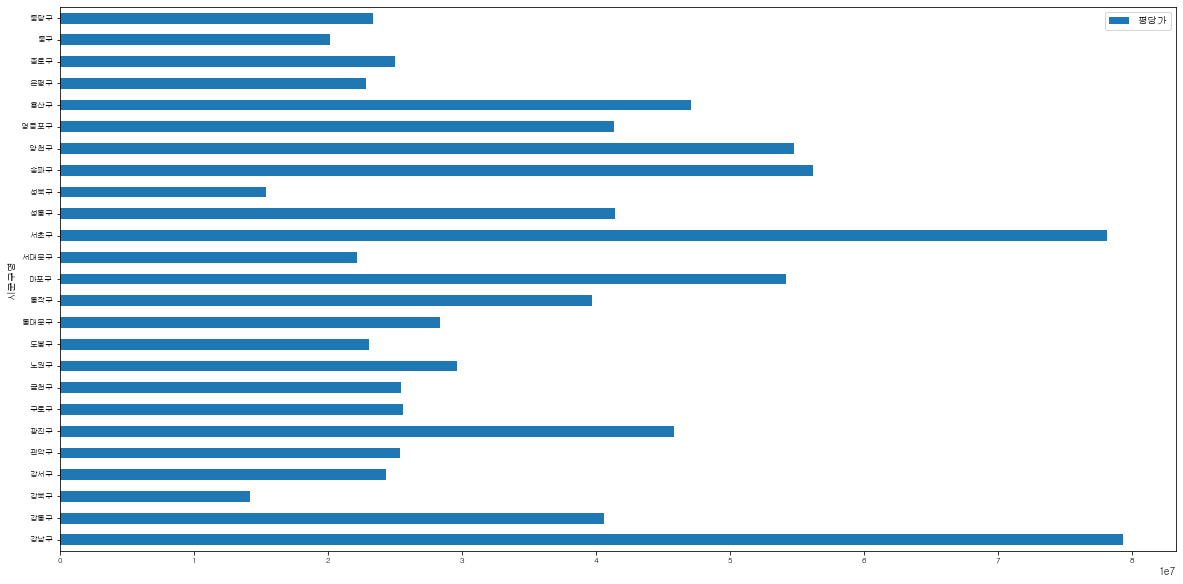

In [42]:
p1.plot(kind="barh",fontsize=8)

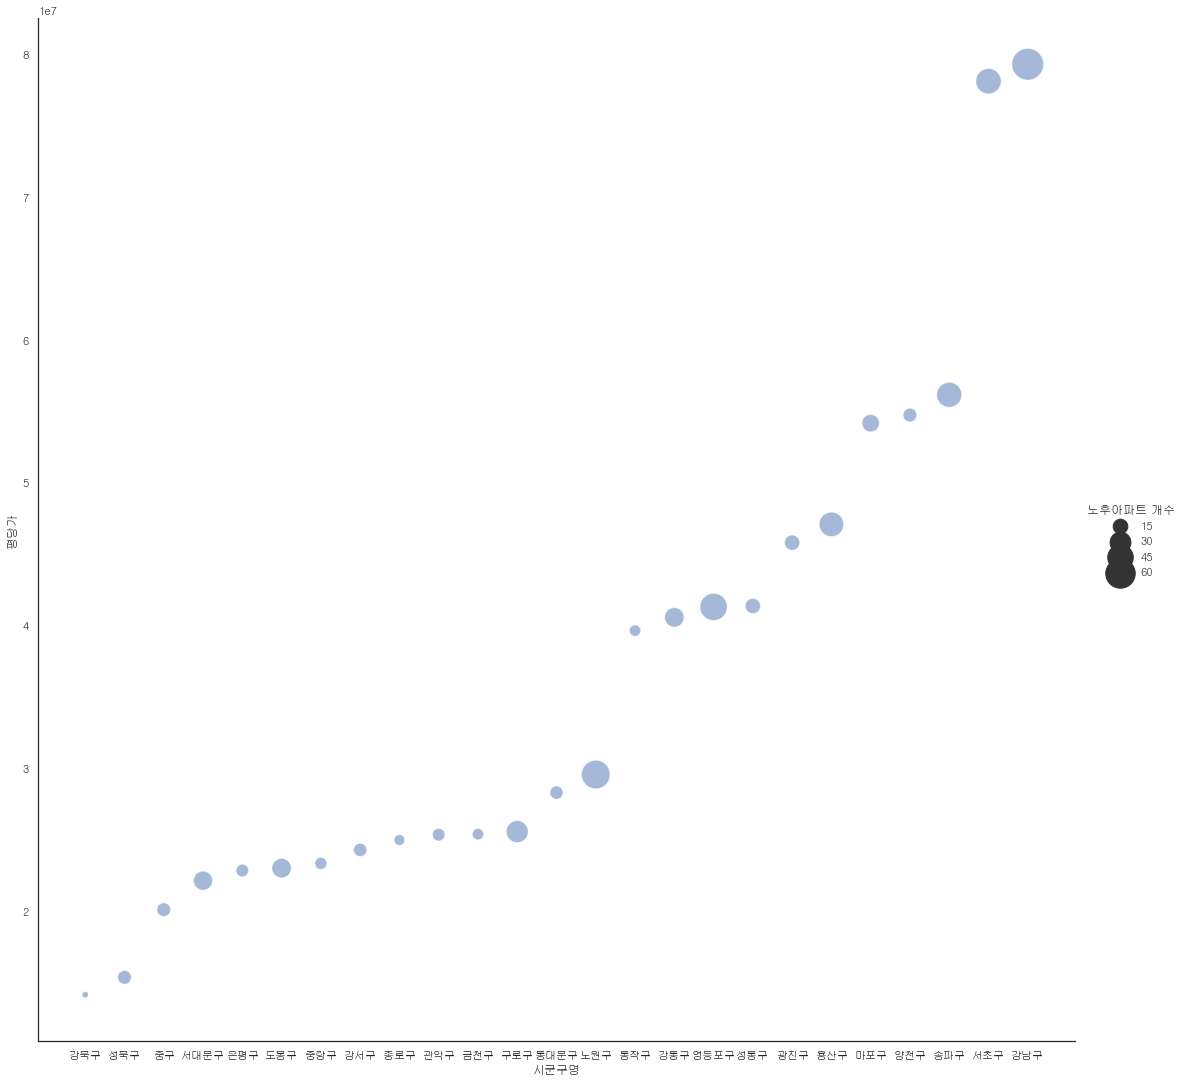

In [43]:
sns.set_theme(style="white")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Gulim'

# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="시군구명", y="평당가", size="노후아파트 개수",
            sizes=(40, 1000), alpha=.5, palette="muted",
            height=15,data=result_sorted_by_values)

### 분석 결과
    건축 된 지 30년 이상 된 노후 아파트가 가장 많은 구는 강남구였고, 노후 아파트 기준 평당가가 가장 높은 지역 역시 강남구였다.  
    노후 아파트는 재개발이 될 가능성이 높으므로 이 점이 선반영되어 평당가에 영향을 미치고 있음을 확인했다. 또한 반대로 노후 아파트 수가 가장 적은 강북구는 평당가 또한 최저로 노후아파트 수가 상대적으로 적어 재개발이 될 가능성이 적다면 평당가또한 낮음을 알 수 있다. 

## 5. 공시지가에 따른 가격비교

In [17]:
price=df.pivot_table('평당가', index=['시군구명'])
price_l=pd.read_csv('../data/공시지가_2020년.csv',encoding='cp949')
price_l=price_l.pivot_table("공시지가(원/㎡)",index=["시군구명"])
price_l['공시지가(평당)'] = (price_l['공시지가(원/㎡)']/3.3)
price_l.drop(['공시지가(원/㎡)'], axis=1, inplace=True)
price = pd.merge(price,price_l,on='시군구명').astype(int)
price_per=price/price.sum(axis=0)
price_per

,평당가,공시지가(평당)
시군구명,,
강남구,0.068968,0.093622
강동구,0.041239,0.034337
강북구,0.027062,0.023138
강서구,0.034208,0.023935
관악구,0.031100,0.034185
광진구,0.045411,0.037399
구로구,0.028139,0.025707
금천구,0.026151,0.025243
노원구,0.029643,0.022848


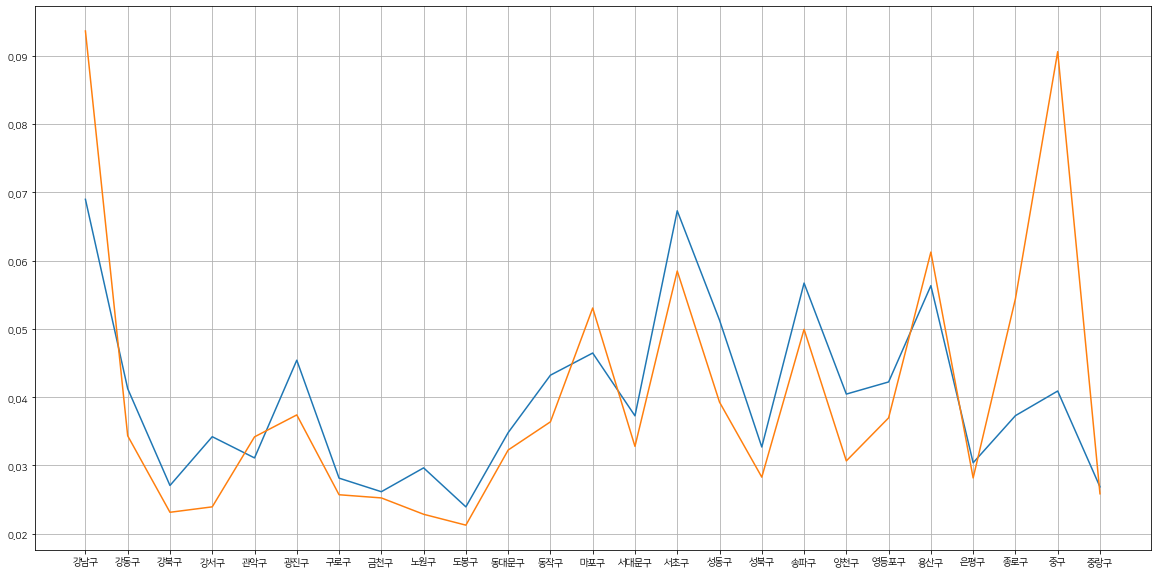

In [18]:
from matplotlib import font_manager, rc
font_path ="C:\\Users\\JIHYUN\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

plt.rcParams["figure.figsize"] = (20,10)

plt.grid(True)

plt.plot(price_per)
plt.show()


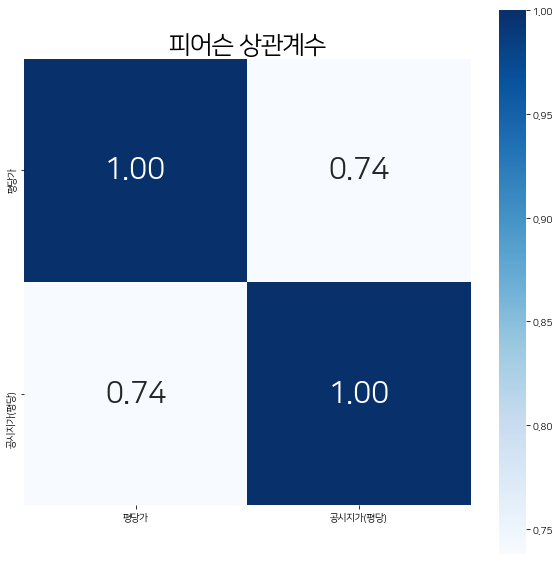

In [20]:
corr = price_per.corr(method = 'pearson') 
corr
plt.figure(figsize=(10,10))
plt.title('피어슨 상관계수',fontsize=25)

result_100_heatmap = sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 30}, fmt = '.2f', square = True, cmap = 'Blues')

## 6. 전체 인구밀도와 가격비교 

In [24]:
people=pd.read_csv('../data/1인당 자동차 등록 대수.csv',encoding='cp949')
people.rename(columns={people.columns[3]:'주민등록인구'}, inplace=True)
people.rename(columns={people.columns[0]:'시군구명'}, inplace=True)
people.drop([people.index[0],people.index[1]], inplace=True)
people.drop(['2020','2020.1'], axis=1, inplace=True)

result = pd.merge(price,people,on='시군구명')
result=result.set_index('시군구명')
result=result.astype(int)
result_per=result/result.sum(axis=0)
result_per


,평당가,공시지가(평당),주민등록인구
시군구명,,,
강남구,0.068968,0.093622,0.055772
강동구,0.041239,0.034337,0.047574
강북구,0.027062,0.023138,0.031862
강서구,0.034208,0.023935,0.060008
관악구,0.031100,0.034185,0.051204
광진구,0.045411,0.037399,0.035857
구로구,0.028139,0.025707,0.041828
금천구,0.026151,0.025243,0.023968
노원구,0.029643,0.022848,0.054097


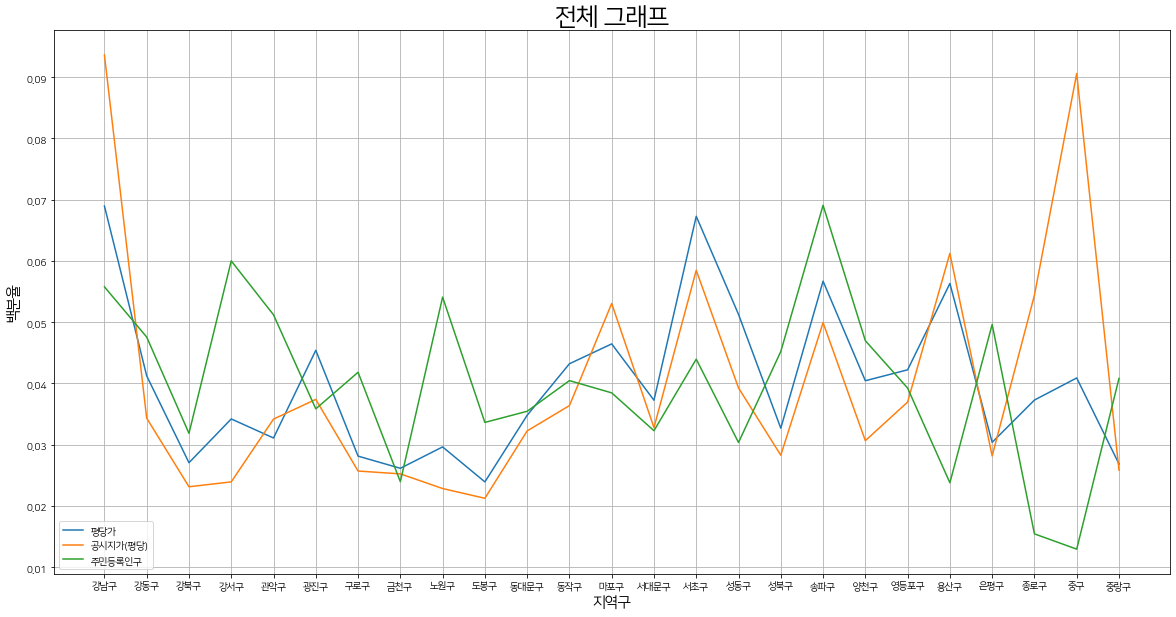

In [25]:
from matplotlib import font_manager, rc
font_path ="C:\\Users\\JIHYUN\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

plt.rcParams["figure.figsize"] = (20,10)


x = result_per.index
y1 = result_per['평당가']
y2 = result_per['공시지가(평당)']
y3 =result_per['주민등록인구']
plt.grid(True)

plt.plot(x,y1,label='평당가')
plt.plot(x,y2,label='공시지가(평당)')
plt.plot(x,y3,label='주민등록인구')

plt.legend()
plt.title('전체 그래프',fontsize=25)
plt.xlabel('지역구',fontsize=15)
plt.ylabel('백분율',fontsize=15)
plt.show()

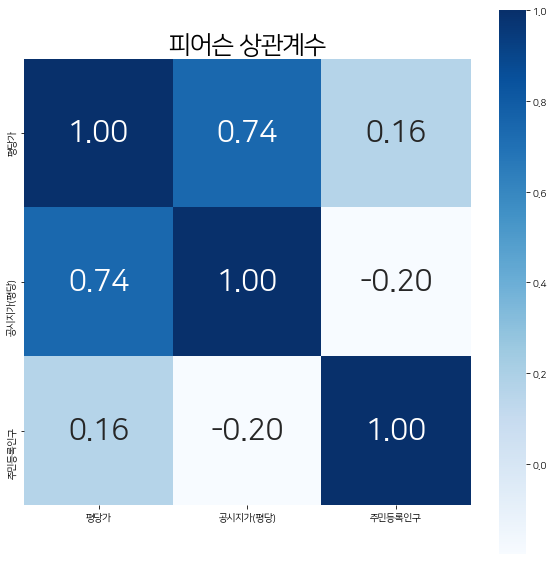

In [29]:
corr = result_per.corr(method = 'pearson') 
corr

plt.figure(figsize=(10,10))
plt.title('피어슨 상관계수',fontsize=25)

result_100_heatmap = sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 30}, fmt = '.2f', square = True, cmap = 'Blues')

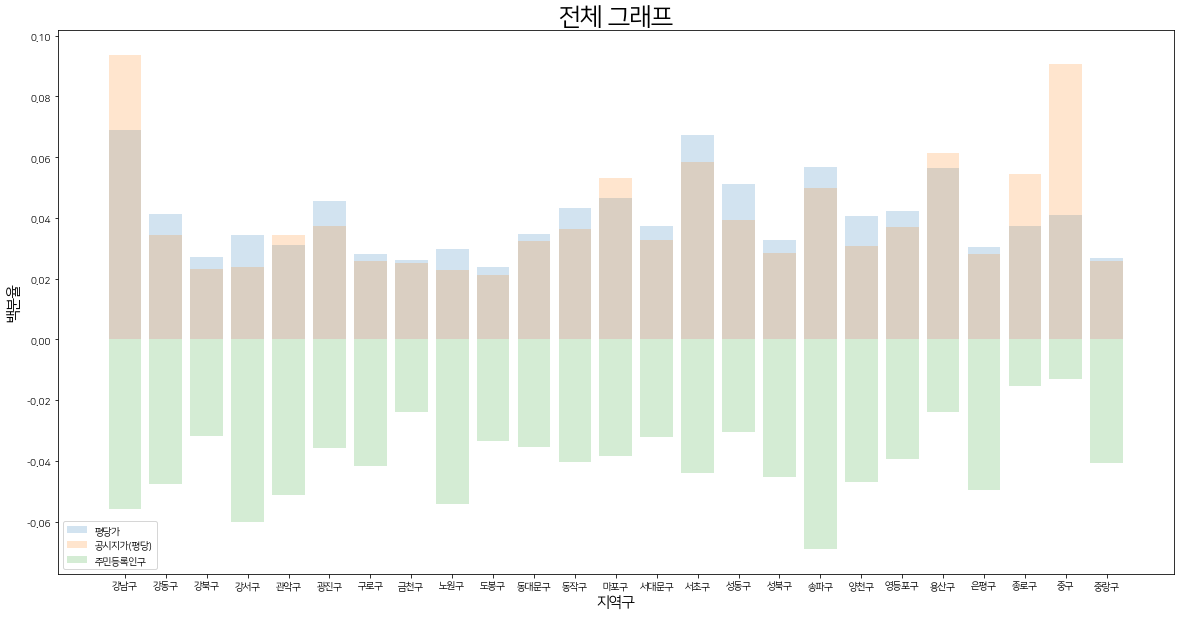

In [27]:
from matplotlib import font_manager, rc
font_path ="C:\\Users\\JIHYUN\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquare.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

plt.rcParams["figure.figsize"] = (20,10)

x = result_per.index
y1 = result_per['평당가']
y2 = result_per['공시지가(평당)']
y3 =-1*result_per['주민등록인구']

fig, ax = plt.subplots()
ax.bar(x, y1,label='평당가',alpha = 0.2)
ax.bar(x, y2,label='공시지가(평당)',alpha = 0.2)
ax.bar(x, y3,label='주민등록인구',alpha = 0.2)

plt.legend()
plt.title('전체 그래프',fontsize=25)
plt.xlabel('지역구',fontsize=15)
plt.ylabel('백분율',fontsize=15)

plt.show()

### 분석결과
    공시지가와 평당가는 어느정도 관련성이 잇는 것을 알 수 있지만 몇 부분 의외인 부분이 있는데 바로 중구, 종로구, 강남구이다. 이 부부은 평당가보다 공시지가의 가격이 월등히 높은데 이 지역들은 주거지역보다 상권으로 가치가 매겨져 아파트 거래가격인 평당가보다 공시지가가 높게 나왔다고 생각할 수 있다.
    또한 당연히 비쌀수록 적게 살고 저렴할수록 더 많이 거주할서라고 생각했는데 결과를 보면 그렇지 않음을 알 수 있다.

## 7. 사설학원과 학생수에 따른 가격비교 


In [ ]:
#구별 사설학원수
privateAcademy = pd.read_table("../data/서울시 학생 1만명당 사설학원수 통계.txt", thousands = ',')
privateAcademy.drop([privateAcademy.index[0]], inplace=True)
privateAcademy['사설학원수'] = privateAcademy['사설학원수'].astype(int)

# 지역별 평당가 평균
df_private = df
pd.options.display.float_format = '{:.5f}'.format
df_private= df_private.groupby(['시군구명'], as_index=False)[['평당가']].mean()
df_private['평당가'] = df_private['평당가'].astype(int)

def remove_comma(x):
    return x.replace(',', '')

# 구별 중, 고등학생 수
studentNum = pd.read_table("../data/서울시 학급당 학생수(구별) 통계.txt", thousands = ',')
studentNum.drop(index = [0, 1, 2], inplace=True)

studentNum = studentNum[['지역', '중학교', '고등학교']]
studentNum.set_index('지역', inplace = True)

# 타입을 int로 변경하기 위해 ',' 없애기
studentNum['중학교']=studentNum['중학교'].apply(remove_comma)
studentNum['고등학교']=studentNum['고등학교'].apply(remove_comma)

# 타입을 int로 바꿈
studentNum=studentNum.astype(int)

studentNum['학생수'] = studentNum.sum(axis=1)

studentNum = studentNum.reset_index()
studentNum.rename(columns = {'지역' : '자치구'}, inplace = True)

# 평당가, 사설학원수, 학생수 merge
df_private.rename(columns = {'시군구명' : '자치구'}, inplace = True)
privateMerge = pd.merge(df_private,privateAcademy,on='자치구')
privateMerge = pd.merge(privateMerge,studentNum,on='자치구')
privateMerge.drop(['기간', '초·중·고 학생수', '학생1만명당 사설학원수', '중학교', '고등학교'], axis=1, inplace=True)
# privateMerge.set_index('자치구', inplace = True)
privateMerge

In [ ]:
x = privateMerge['자치구']
y1 = privateMerge['평당가']
y2 = privateMerge['사설학원수']
y3 = privateMerge['학생수']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()

plt.grid(True)

data_y1 = ax1.plot(x, y1, color='b', label='평당가')
data_y2 = ax2.plot(x, y2, color='r', label='사설학원수')
data_y3 = ax3.plot(x, y3, color='g', label='학생 수')

ax1.set_xlabel('자치구')
ax1.set_ylabel('평당가')
ax2.set_ylabel('사설학원수')
ax3.set_ylabel('학생수')

data_y = data_y1+data_y2+data_y3
labels = [l.get_label() for l in data_y]

plt.legend(data_y, labels, loc=1)

plt.show()

### 분석결과
    대체적으로 각 구마다의 중·고등학생수, 사설학원수와 평당가는 비례하는 것을 알 수 있다.
    하지만 사무실이 많이 모여있는 업무지역인 중구와 용산구는 학생수, 학원수와 평당가가 비례하지 않는다는 것을 알 수 있었다.
    또한 주거지역인 강서구와 노원구 같은 경우 학생수에 비해 평당가는 낮다는 것을 알 수 있다.
    